In [1]:
%matplotlib inline

In [2]:
import os
import json
from collections import namedtuple
from itertools import product
import tqdm
import pandas as pd
import seaborn as sns
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

rc('text', usetex=False)

In [152]:
paramSpace = {
    "is-peeler-prior": [.01, .05, .1, .2, .3],
    "peeler-efficacy": [.99, .9, .8, .7],
    "alt-peel-prob": [.1, .3, .5, .7, .9],
    
    "peeling-goal-prior": [1.0],
    "step-cost": [-.1],
    'teaching-weight': [1, 5, 10], #[1, 5, 10],
    'softmax_temp': [.2],
    'randchoose': [0.0],
}

paramnames, paramvals = zip(*paramSpace.items())
allfn = os.listdir('simulations')
iteration = tqdm.tqdm(list(product(*paramvals)))
for paramassns in iteration:
    params = dict(zip(paramnames, paramassns))
    param_hash = hash(tuple(sorted(zip(paramnames, paramassns))))
    params['simname'] = str(param_hash).replace('-', '_')
    if (params['simname']+".json" in allfn):
        continue
    json.dump(params, open('sim_config.json', 'w'))
    res = os.system(f'webppl run_sim.wppl --require . --require webppl-json -- --config sim_config.json')
    if res != 0:
        raise Exception("Error")

100%|██████████| 300/300 [28:31<00:00,  5.70s/it]


In [209]:
allfn = os.listdir('simulations')
allsims = []
for fn in allfn:
    if fn == 'hernik_test.json':
        continue
    simres = json.load(open(f'./simulations/{fn}'))
    for cond in simres['conditions']:
        allsims.append({**cond, **simres['config']})

In [210]:
sims = pd.DataFrame(allsims)

In [211]:
def code_congruent(row):
    if row['name'].split('+')[0] == 'changed':
        congruent = row['p(use-tool,peeled)']
        incongruent = row['p(use-tool,unpeeled)']
    elif row['name'].split('+')[0] == 'unchanged':
        congruent = row['p(use-tool,unpeeled)']
        incongruent = row['p(use-tool,peeled)']
    return pd.Series({
        'congruent': -np.log(congruent),
        'incongruent': -np.log(incongruent),
        'logratio': np.log(congruent/incongruent)
    })
sims = pd.concat([sims, sims.apply(code_congruent, axis=1)], axis=1)

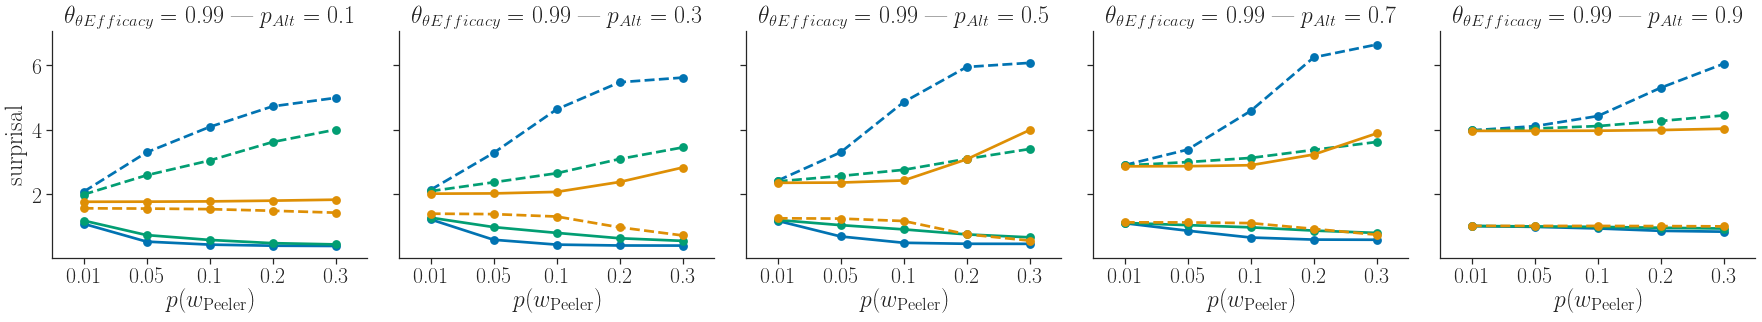

In [212]:
rc('text', usetex=True)
rc("text.latex", preamble=[r'\usepackage{amsmath}'])
sns.set(font_scale=2, style="ticks", font="Times New Roman")

paramnames = [
    "is-peeler-prior",
    "peeler-efficacy",
    "alt-peel-prob",
    
    "peeling-goal-prior",
    "step-cost",
    'teaching-weight',
    'softmax_temp',
    'randchoose'
]
toplot = sims.melt(
    id_vars=['name', ]+paramnames,
    value_vars=['congruent', 'incongruent'],
    value_name='surprisal',
    var_name='trialtype'
)
toplot['name:trialtype'] = toplot['name']+':'+toplot['trialtype']
name_order = sorted(toplot['name:trialtype'].unique())
pPeeler = r'$p(w_{\text{Peeler}})$'
toplot[pPeeler] = toplot['is-peeler-prior']
efficacy = r'$\theta_{\theta{Efficacy}}$'
toplot[efficacy] = toplot['peeler-efficacy']
pAlt = r'$p_{Alt}$'
toplot[pAlt] = toplot['alt-peel-prob']

g = sns.catplot(
    data=toplot[
        (toplot['teaching-weight'] == 5)
        & (toplot['peeler-efficacy'] == .99)
    ],
    y='surprisal',
    x=pPeeler,
    row=efficacy,
    col=pAlt,
    hue='name:trialtype',
    kind='point',
    hue_order=name_order,
    palette={n: cp[0] if "changed+comm" in n else (cp[1] if "unchanged+com" in n else cp[2]) for n in name_order},
    markers=["o" if "congruent" in n else 'x' for n in name_order],
    linestyles=['--' if 'incongruent' in n else '-' for n in name_order],
    legend=False
)

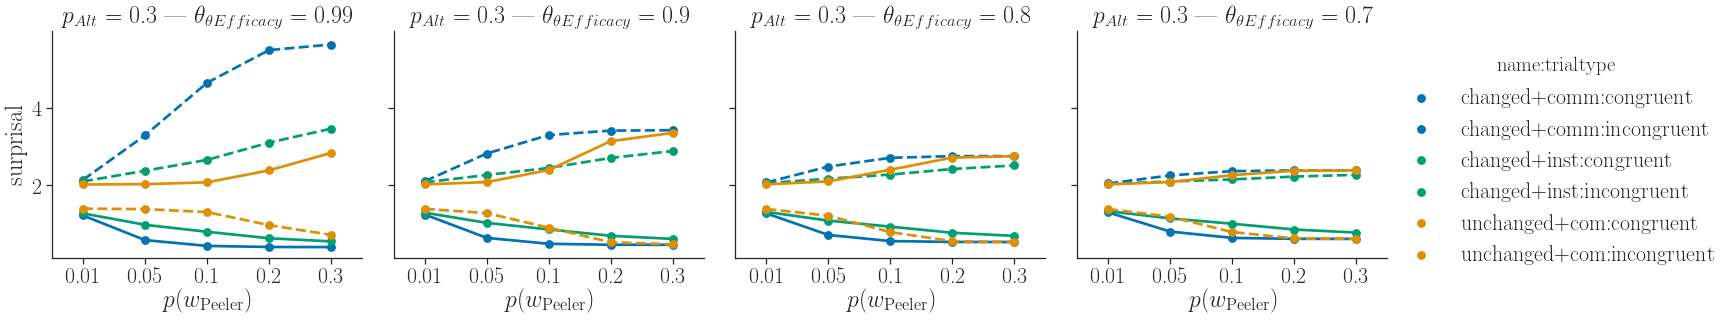

In [213]:
rc('text', usetex=True)
rc("text.latex", preamble=[r'\usepackage{amsmath}'])
sns.set(font_scale=2, style="ticks", font="Times New Roman")

paramnames = [
    "is-peeler-prior",
    "peeler-efficacy",
    "alt-peel-prob",
    
    "peeling-goal-prior",
    "step-cost",
    'teaching-weight',
    'softmax_temp',
    'randchoose'
]
toplot = sims.melt(
    id_vars=['name', ]+paramnames,
    value_vars=['congruent', 'incongruent'],
    value_name='surprisal',
    var_name='trialtype'
)
toplot['name:trialtype'] = toplot['name']+':'+toplot['trialtype']
name_order = sorted(toplot['name:trialtype'].unique())
pPeeler = r'$p(w_{\text{Peeler}})$'
toplot[pPeeler] = toplot['is-peeler-prior']
efficacy = r'$\theta_{\theta{Efficacy}}$'
toplot[efficacy] = toplot['peeler-efficacy']
pAlt = r'$p_{Alt}$'
toplot[pAlt] = toplot['alt-peel-prob']

g = sns.catplot(
    data=toplot[
        (toplot['teaching-weight'] == 5)
        & (toplot['alt-peel-prob'] == .3)
    ],
    y='surprisal',
    x=pPeeler,
    col=efficacy,
    col_order=sorted(toplot[efficacy].unique(), reverse=True),
    row=pAlt,
    hue='name:trialtype',
    kind='point',
    hue_order=name_order,
    palette={n: cp[0] if "changed+comm" in n else (cp[1] if "unchanged+com" in n else cp[2]) for n in name_order},
    markers=["o" if "congruent" in n else 'x' for n in name_order],
    linestyles=['--' if 'incongruent' in n else '-' for n in name_order],
)

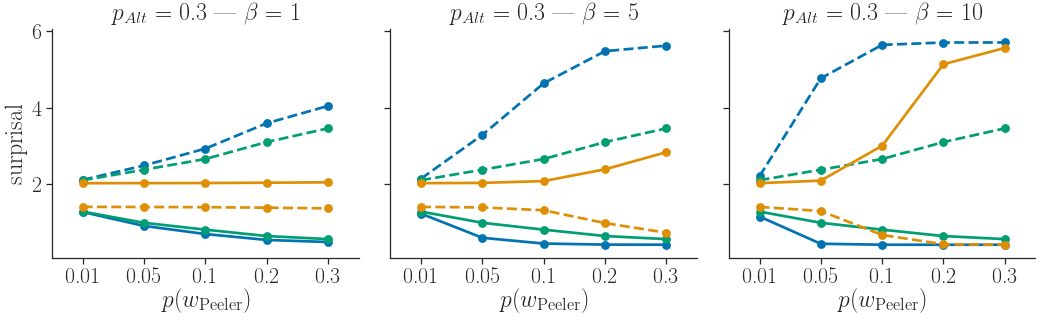

In [214]:
rc('text', usetex=True)
rc("text.latex", preamble=[r'\usepackage{amsmath}'])
sns.set(font_scale=2, style="ticks", font="Times New Roman")

paramnames = [
    "is-peeler-prior",
    "peeler-efficacy",
    "alt-peel-prob",
    
    "peeling-goal-prior",
    "step-cost",
    'teaching-weight',
    'softmax_temp',
    'randchoose'
]
toplot = sims.melt(
    id_vars=['name', ]+paramnames,
    value_vars=['congruent', 'incongruent'],
    value_name='surprisal',
    var_name='trialtype'
)
toplot['name:trialtype'] = toplot['name']+':'+toplot['trialtype']
name_order = sorted(toplot['name:trialtype'].unique())
pPeeler = r'$p(w_{\text{Peeler}})$'
toplot[pPeeler] = toplot['is-peeler-prior']
efficacy = r'$\theta_{\theta{Efficacy}}$'
toplot[efficacy] = toplot['peeler-efficacy']
pAlt = r'$p_{Alt}$'
toplot[pAlt] = toplot['alt-peel-prob']
tweight = r'$\beta$'
toplot[tweight] = toplot['teaching-weight']

g = sns.catplot(
    data=toplot
    [
        (toplot['peeler-efficacy'] == .99)
        & (toplot['alt-peel-prob'] == .3)
    ]
    ,
    y='surprisal',
    x=pPeeler,
    col=tweight,
    col_order=sorted(toplot[tweight].unique(), reverse=False),
    row=pAlt,
    hue='name:trialtype',
    kind='point',
    hue_order=name_order,
    palette={n: cp[0] if "changed+comm" in n else (cp[1] if "unchanged+com" in n else cp[2]) for n in name_order},
    markers=["o" if "congruent" in n else 'x' for n in name_order],
    linestyles=['--' if 'incongruent' in n else '-' for n in name_order],
    legend=False
)

(0, 5.1)

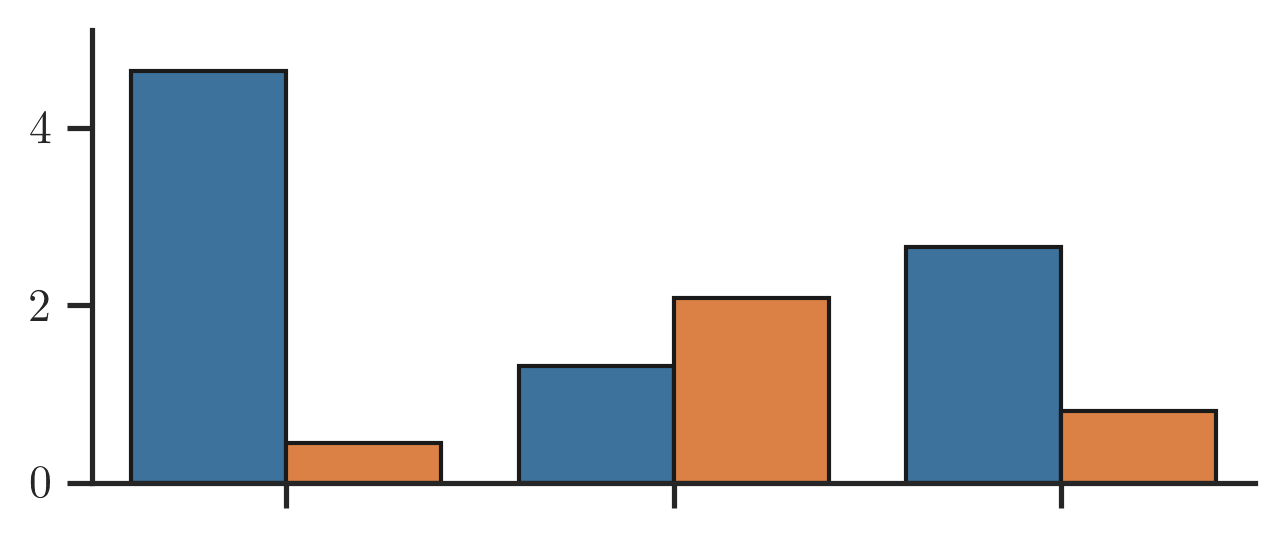

In [215]:
sns.set(font_scale=1, style="ticks", font="Times New Roman")
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(5, 2))

toplot = sims.merge(pd.DataFrame([{
    "is-peeler-prior": .1,
    "peeler-efficacy": .99,
    "alt-peel-prob": .3,
    
    "peeling-goal-prior": 1.0,
    "step-cost": -.1,
    'teaching-weight': 5,
    'softmax_temp': .2,
    'randchoose': 0.0,
}]))
toplot = toplot.melt(
    id_vars='name',
    value_vars=['congruent', 'incongruent'],
    value_name='surprisal',
    var_name='trialtype'
)
g = sns.barplot(
    data=toplot,
    x='name',
    y='surprisal',
    hue='trialtype',
    hue_order=['incongruent', 'congruent'],
    ax=ax,
    palette=['#2c74ac', '#f47c2c'],
    ec='k', lw=1
)
g.legend().remove()
sns.despine()
ylab = g.set_ylabel("")
g.set_xlabel("")
g.set_xticklabels(['', ''])
g.set_ylim(0, 5.1)

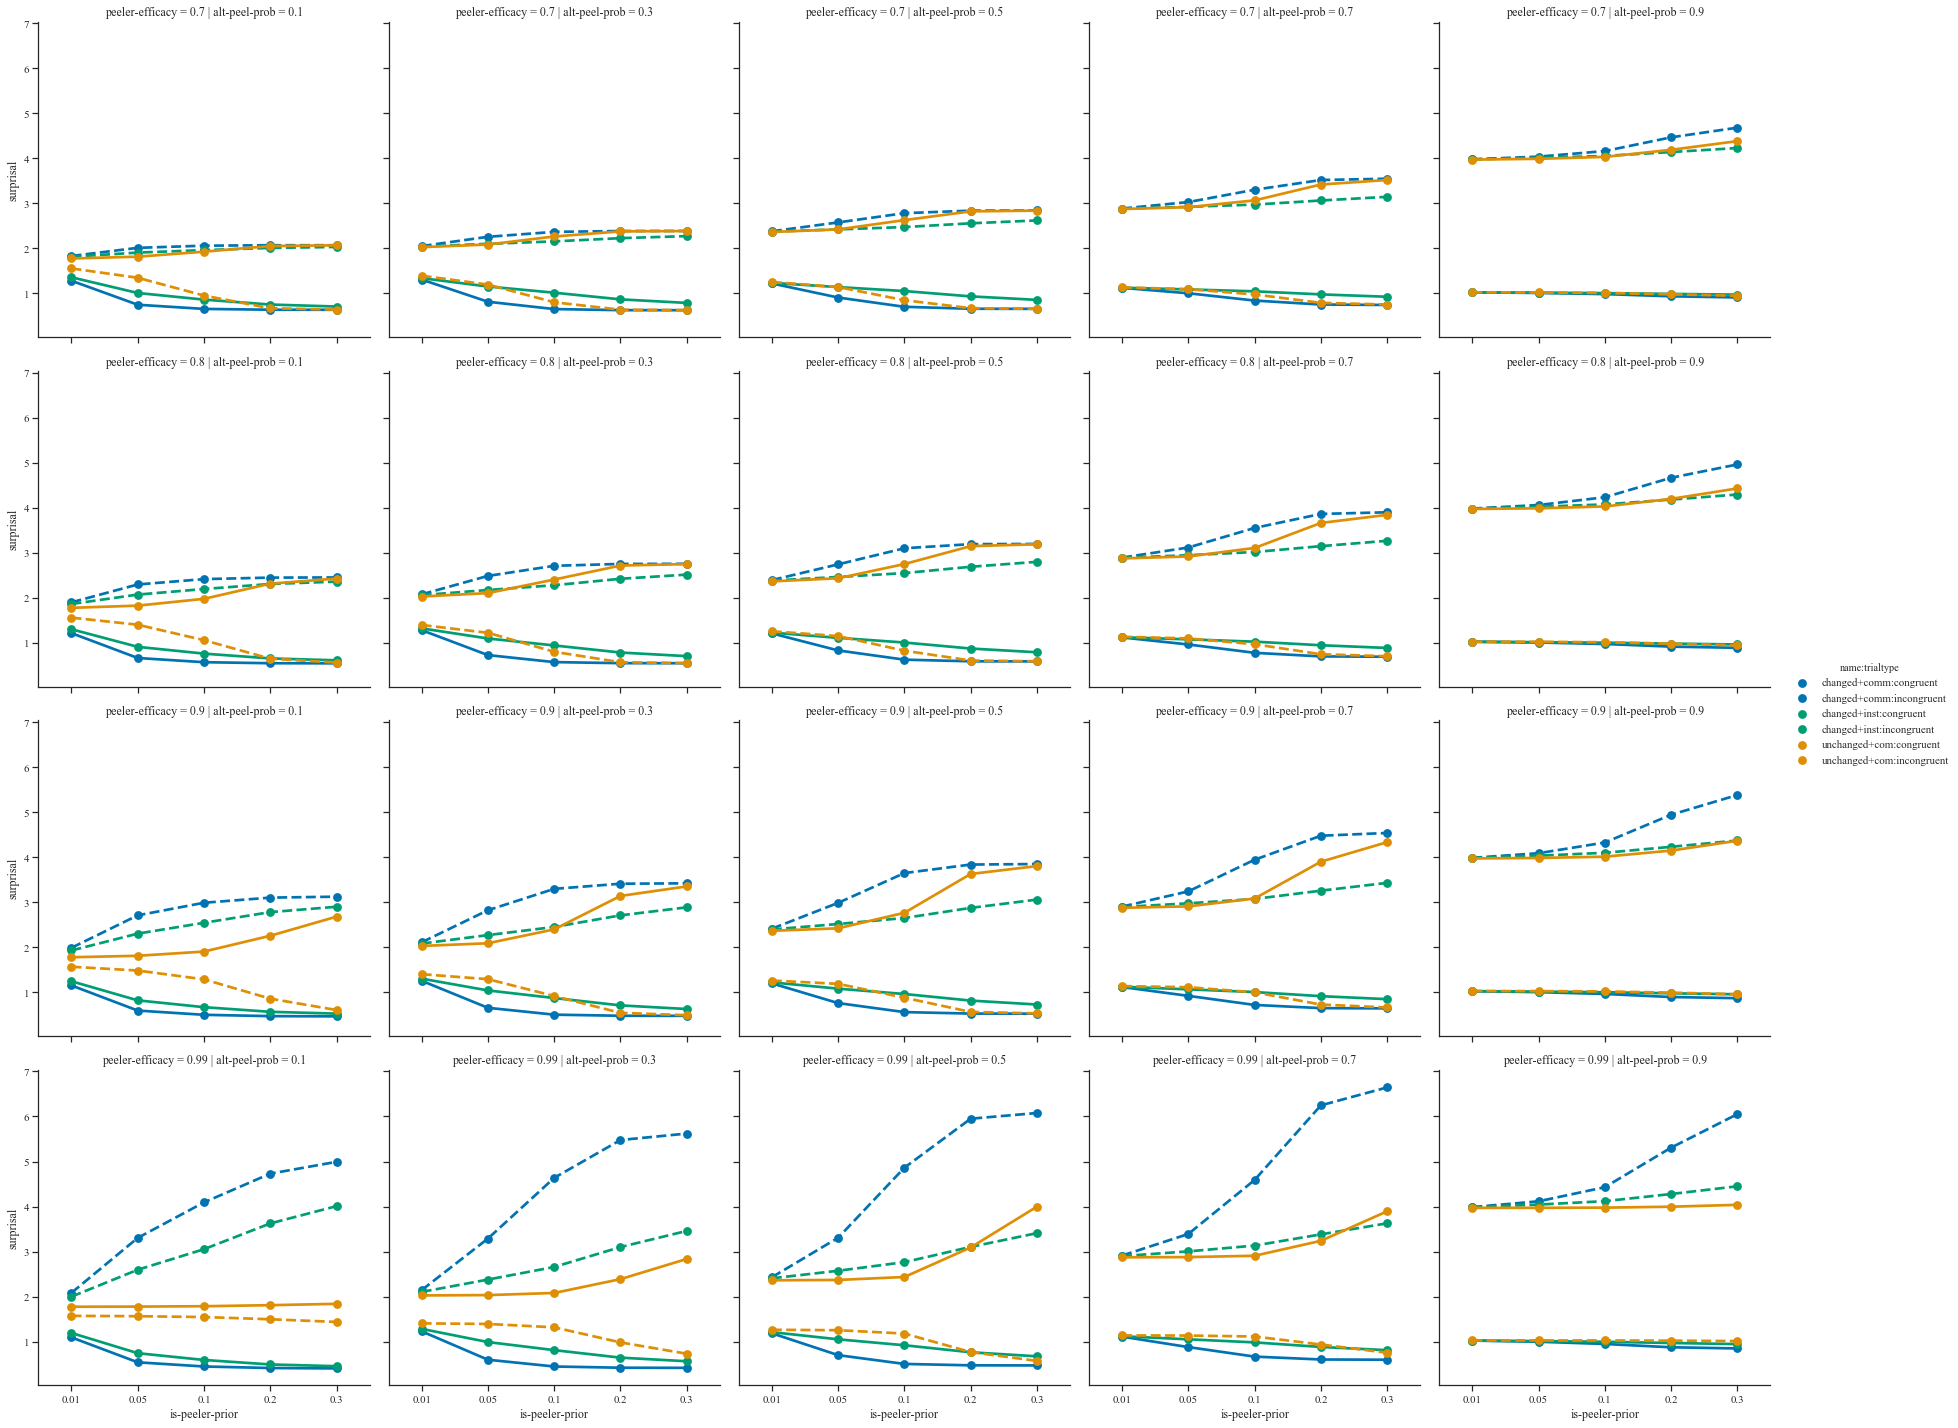

In [176]:
paramnames = [
    "is-peeler-prior",
    "peeler-efficacy",
    "alt-peel-prob",
    
    "peeling-goal-prior",
    "step-cost",
    'teaching-weight',
    'softmax_temp',
    'randchoose'
]
toplot = sims.melt(
    id_vars=['name', ]+paramnames,
    value_vars=['congruent', 'incongruent'],
    value_name='surprisal',
    var_name='trialtype'
)
toplot['name:trialtype'] = toplot['name']+':'+toplot['trialtype']
name_order = sorted(toplot['name:trialtype'].unique())
sns.catplot(
    data=toplot[
        toplot['teaching-weight'] == 5
    ],
    y='surprisal',
    x='is-peeler-prior',
    row='peeler-efficacy',
    col='alt-peel-prob',
    hue='name:trialtype',
    kind='point',
    hue_order=name_order,
    palette={n: cp[0] if "changed+comm" in n else (cp[1] if "unchanged+com" in n else cp[2]) for n in name_order},
    markers=["o" if "congruent" in n else 'x' for n in name_order],
    linestyles=['--' if 'incongruent' in n else '-' for n in name_order],
)